In [10]:
import numpy as np
import cv2
import math
import time

def find_mask(frame):
    blurred = cv2.blur(frame, (5, 5))
    
    mask = cv2.inRange(blurred, (0, 0, 0), (200, 50, 50))
    
    
    connectivity = 4  
    
    output = cv2.connectedComponentsWithStats(mask, connectivity, cv2.CV_32S)
    
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    
    dots = []
    
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        top = stats[i, cv2.CC_STAT_TOP]
        left = stats[i, cv2.CC_STAT_LEFT]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        
        color = (123, 150, 12)
        
        if (area >= 10 and area < 400 and width / height < 3 and height / width < 3):
            color = (12, 14, 230)
            
            dots.append((left + width // 2, top + height // 2))
            
            cv2.rectangle(frame, (left, top), (left + width, top + height), color, 3)
            
    return mask, dots
            
def draw_line(frame, a, b, xmin, xmax, color = (123, 23, 35)):
    y1 = int(a * xmin + b)
    y2 = int(a * xmax + b)
        
    cv2.line(frame, (int(xmin), int(y1)), (int(xmax), int(y2)), color, 3)
    
def draw_line_r_theta(frame, r, theta, xmin, xmax, color = (123, 23, 35)):
    a = math.tan(theta)
    
    x0 = r * math.cos(theta + math.pi / 2)
    y0 = r * math.sin(theta + math.pi / 2)
    
    b = y0 - x0 * a
    
    draw_line(frame, a, b, xmin, xmax, color)
    
    
def repack_data(dots):
    n = len(dots)
    x = np.zeros((n))
    y = np.zeros((n))
    
    for i in range(n):
        x[i], y[i] = dots[i]
    
    xmin = min(x)
    xmax = max(x)
    
    return n, x, y, xmin, xmax

def calc_distance(a, b, dot):
    x, y = dot

    dist = abs(y - a * x - b) / math.sqrt(a**2 + 1)

    return dist

def r_thera_by_a_b(a, b):
    r = abs(b) / math.sqrt(a**2 + 1)
    theta = math.atan(a)
    
    return r, theta

def LSE(dots):
    n, x, y, xmin, xmax = repack_data(dots)
    
    Ysum = sum(y)
    Xsum = sum(x)
    XYsum = sum(x * y)
    X2sum = sum(x * x)
    
    b_hat = (Ysum * X2sum - XYsum * Xsum) / (n * X2sum - Xsum**2)
    a_hat = (XYsum - b_hat * Xsum) / X2sum
    
    return a_hat, b_hat, xmin, xmax

def Hough_transform(dots, rho, d, coord_max, frame):
    n, x, y, xmin, xmax = repack_data(dots)
    
    ang_num = int(math.pi /  rho)
    sp_num = int(coord_max / d)
    
    accum = np.zeros((ang_num, sp_num), np.uint8)
    
    for i in range(n):
        xd, yd = dots[i]
        
        for j in range(ang_num):
            ang = rho * j - math.pi / 2
            
            a = math.tan(ang)
            b = yd - a * xd
            
            r, _ = r_thera_by_a_b(a, b)
            
            accum[j, int(r / d)] += 1

    cv2.imshow('accum', cv2.resize(accum * 100, (1000, 250), cv2.WARP_INVERSE_MAP))
    
    theta_max, r_max = np.unravel_index(accum.argmax(), accum.shape)
    
    return r_max * d, theta_max * rho - math.pi / 2, xmin, xmax

def RANSAC(dots, alpha, P, eps, frame):
    n, x, y, xmin, xmax = repack_data(dots)
    
    m = math.ceil(math.log2(1 - P) / math.log2(1 - alpha**2))
    
    r_hat, theta_hat = 0, 0
    max_inl_num = 0
    
    for i in range(m):
        #subsample
        p1 = dots[np.random.randint(n)]
        p2 = dots[np.random.randint(n)]
        
        #model
        if (p1 == p2 or p1[0] == p2[0]):
            continue
        
        a = (p1[1] - p2[1]) / (p1[0] - p2[0])
        b = p1[1] - a * p1[0]
        
        inl_num = 0
        
        #evaluate
        for j in range(n):
            curr_dist = calc_distance(a, b, dots[j])
            
            if (curr_dist < eps): 
                inl_num += 1
        
        if (max_inl_num < inl_num):
            max_inl_num = inl_num
            
            r_hat, theta_hat = r_thera_by_a_b(a, b)
    
    return r_hat, theta_hat, xmin, xmax
    

filename = "dotswhitenoise.mp4"

cam = None

while (True):
    if (cam is None):
        reopen_cam = True

    else:
        success, frame = cam.read()

        if (success == False):
            cam.release()
            reopen_cam = True
        
        else:
            w, h, _ = frame.shape
    
    if (reopen_cam == True):
        reopen_cam = False
        
        cam = cv2.VideoCapture(filename)
        
        continue
        
    mask, dots = find_mask(frame)
    
    # LSM
    # ah, bh, xmin, xmax = LSE(dots)
    # draw_line(frame, ah, bh, xmin, xmax)
    
    #Hough Transform
    r, theta, xmin, xmax = Hough_transform(dots, 0.05, 5, math.sqrt(w**2 + h**2), frame)
    draw_line_r_theta(frame, r, theta, xmin, xmax, (123, 234, 234))
    
    #RANSAC
    # r, theta, xmin, xmax = RANSAC(dots, 0.6, 0.99, 15, frame)
    # draw_line_r_theta(frame, r, theta, xmin, xmax, (123, 234, 234))
    
    cv2.imshow("frame", frame)
    cv2.imshow("mask", mask)

    #cv2.waitKey(0)
    
    key = cv2.waitKey(80) & 0xFF
    
    if (key == ord('q')):
        break

cam.release()
#cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(10)

-1

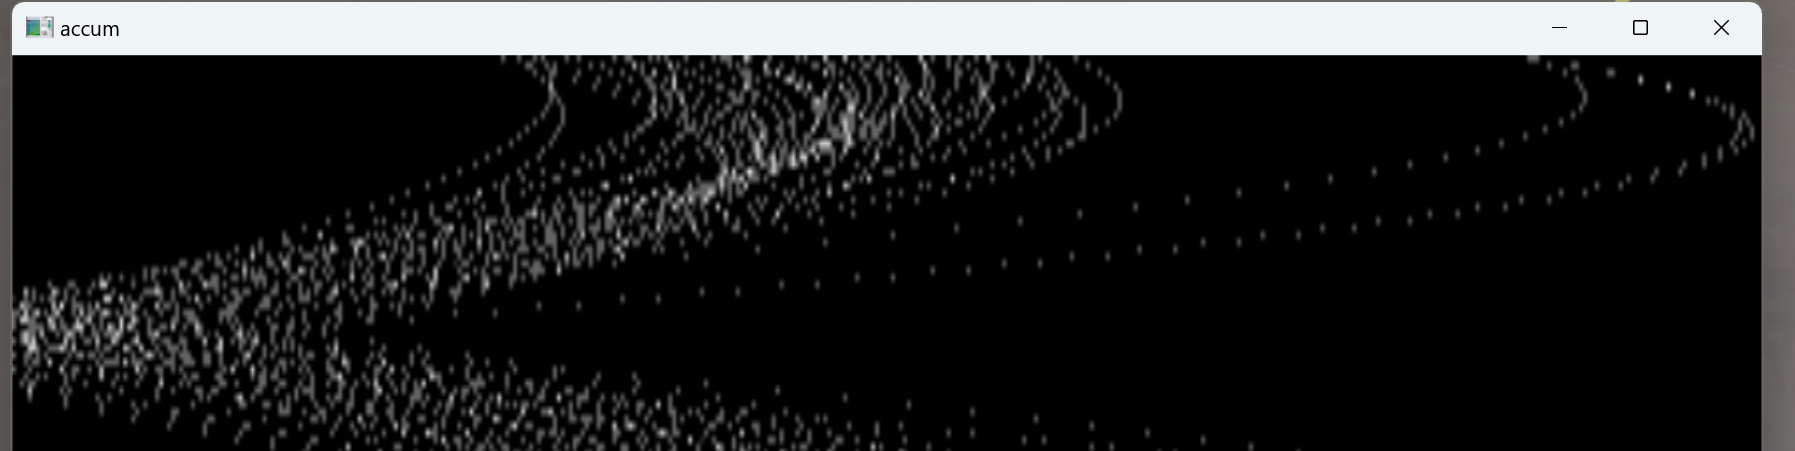

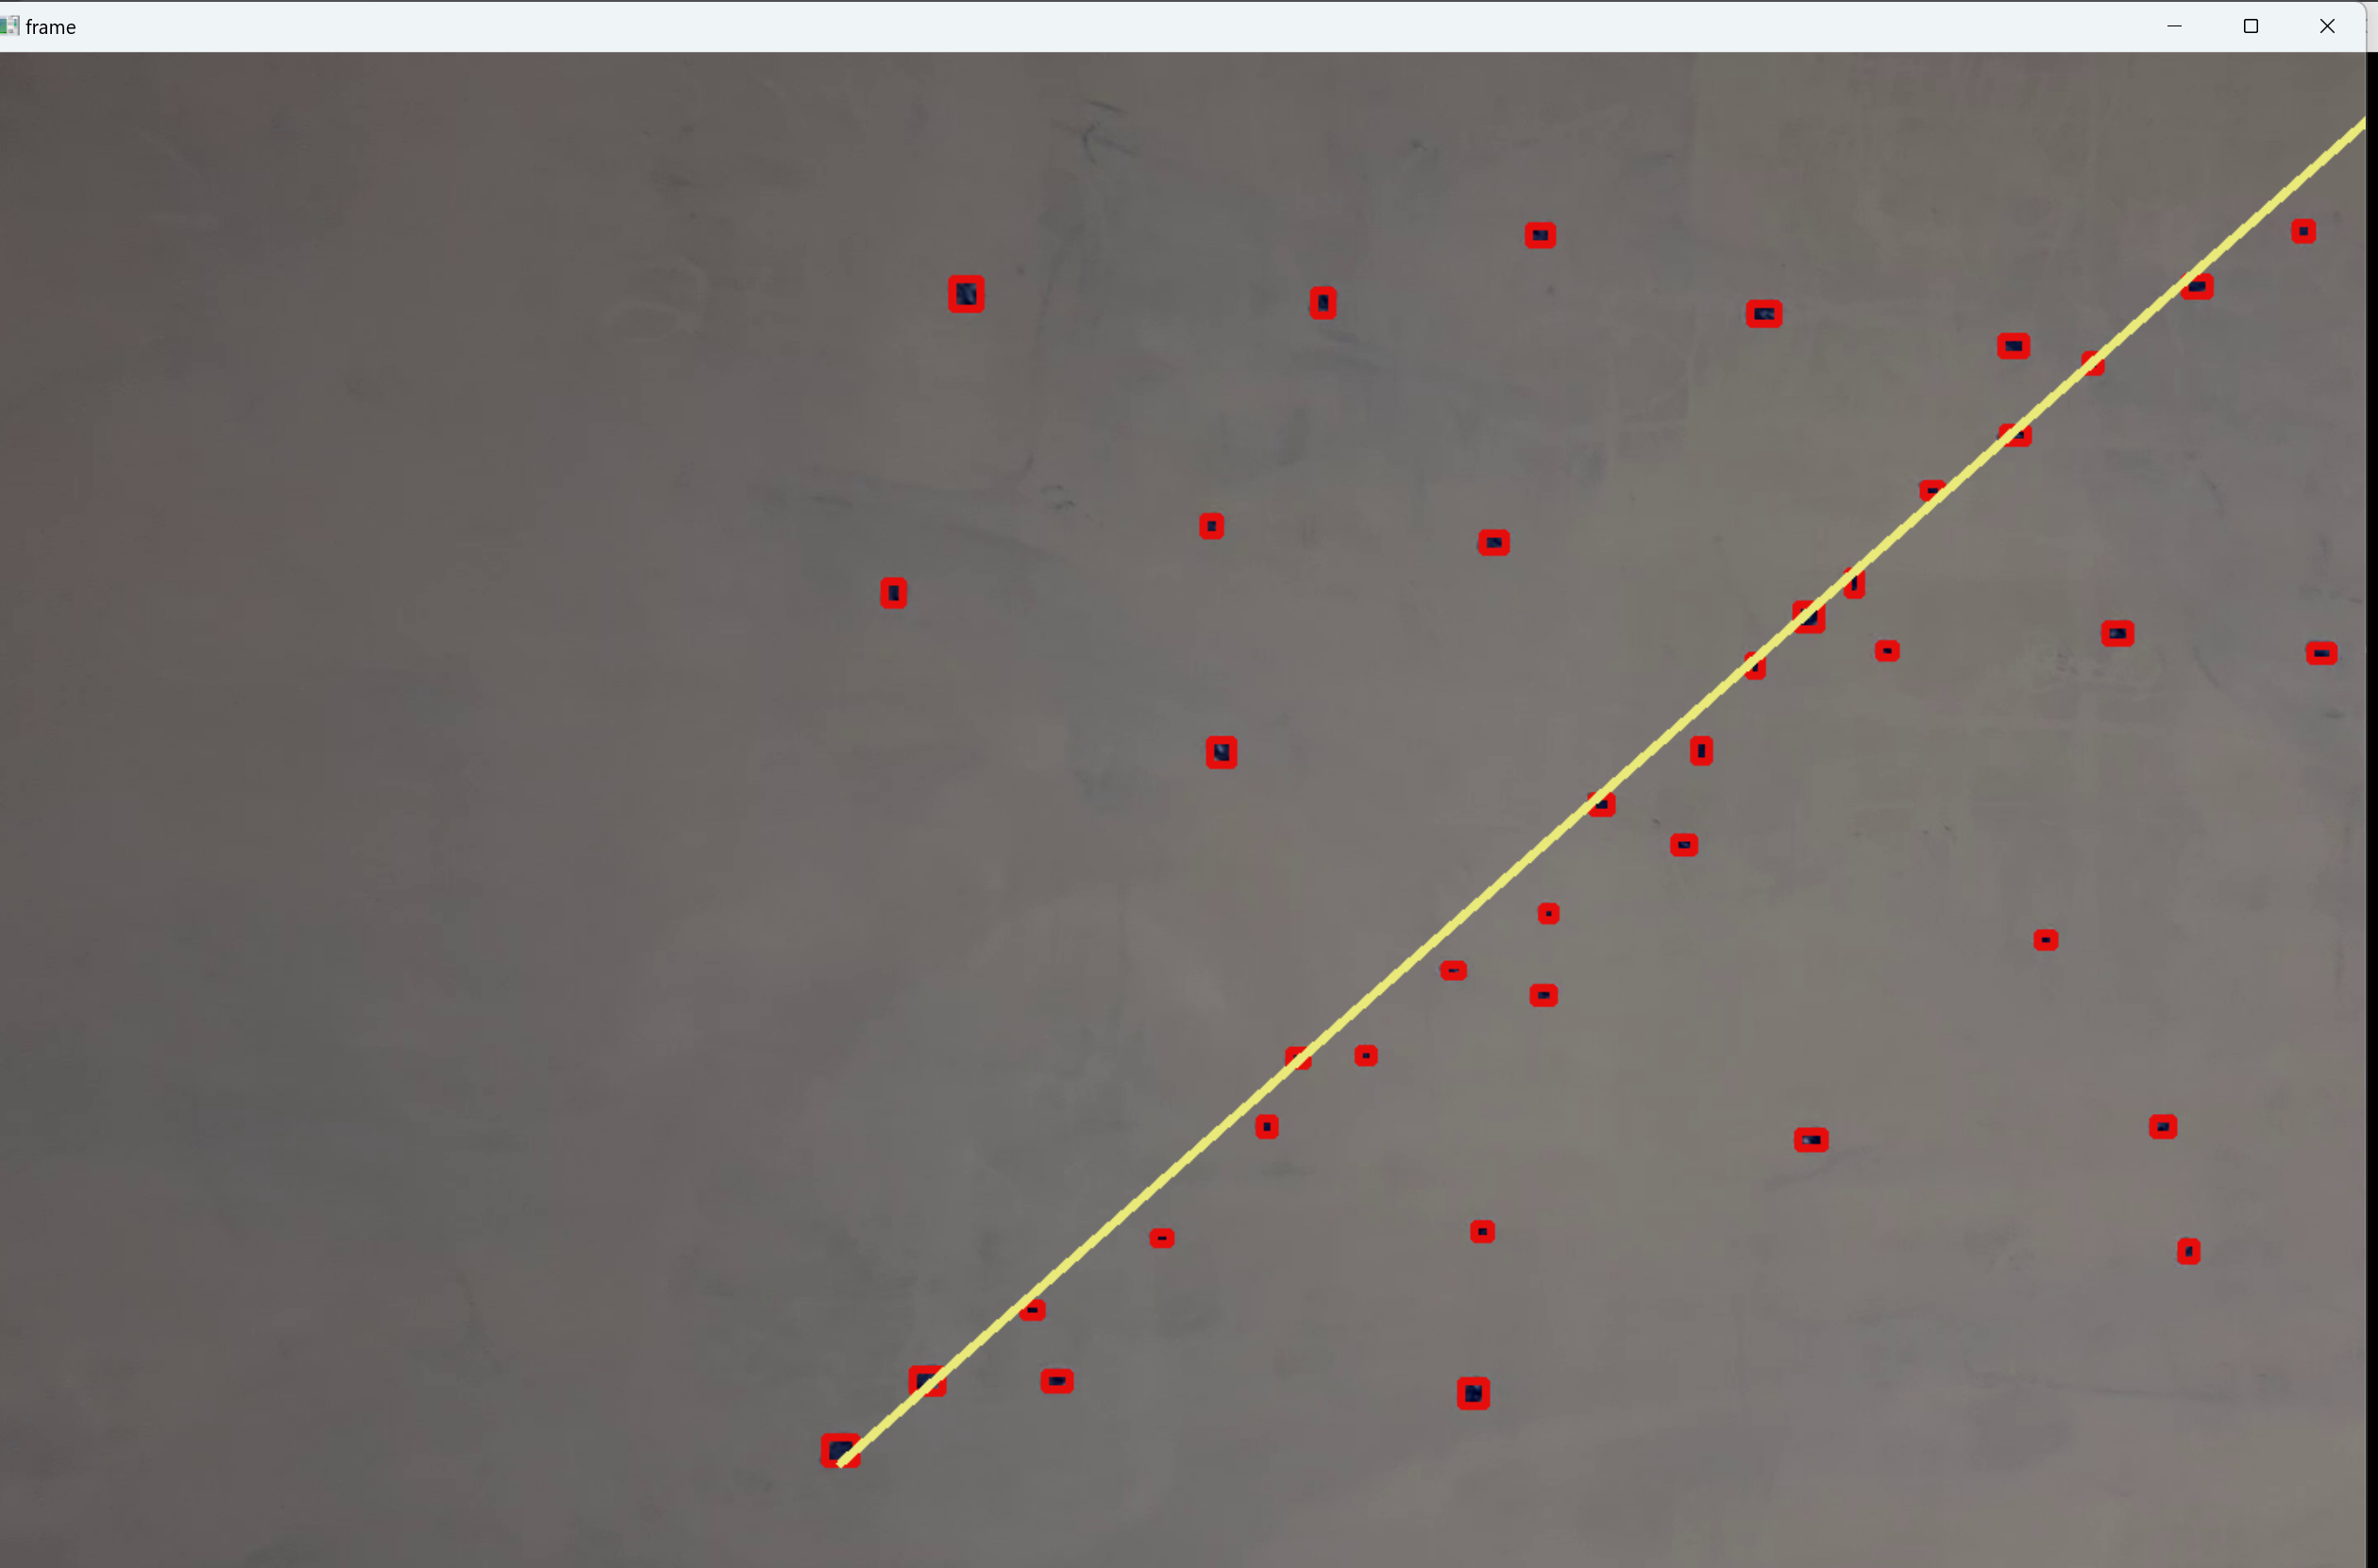